<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/3_3_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__,pl.__version__

('2.0.1+cu118', '2.0.3')

# Optimization

```python
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0,
                weight_decay=0, nesterov=False, *, maximize=False)
```

# Batch / Weight / Layer Normalization 비교

In [ ]:
from torchvision.transforms import ToTensor
import numpy as np


#### Batch_size 변경 ####
_batch_size = 32

download_root = './MNIST'
train_dataset = MNIST(download_root, train=True, download=True,transform=ToTensor())
trainDataLoader = DataLoader(train_dataset, _batch_size, True)

test_dataset = MNIST(download_root, train=False, download=True,transform=ToTensor())
valDataLoader = DataLoader(test_dataset, _batch_size, False)

100%|██████████| 9912422/9912422 [00:00<00:00, 241266175.99it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 28576478.85it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 240536011.29it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3522005.69it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


In [ ]:
p(trainDataLoader.dataset)

[]:
Type: <class 'torchvision.datasets.mnist.MNIST'>
Values: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
batch_n = len(trainDataLoader.dataset) // _batch_size
batch_n

1875

### Batch Normalization

In [ ]:
# MLP model
loss_function = nn.CrossEntropyLoss()
class MLP(pl.LightningModule):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.BatchNorm1d(10))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = MLP()
summary(model, input_size=(_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Flatten: 2-1                      [32, 784]                 --
│    └─Linear: 2-2                       [32, 32]                  25,120
│    └─BatchNorm1d: 2-3                  [32, 32]                  64
│    └─ReLU: 2-4                         [32, 32]                  --
│    └─Linear: 2-5                       [32, 10]                  330
│    └─BatchNorm1d: 2-6                  [32, 10]                  20
Total params: 25,534
Trainable params: 25,534
Non-trainable params: 0
Total mult-adds (M): 0.82
Input size (MB): 0.10
Forward/backward pass size (MB): 0.02
Params size (MB): 0.10
Estimated Total Size (MB): 0.22

In [ ]:
%%time
model = MLP()
_epochs=20
name="mlp"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger,accelerator="auto",
                     limit_train_batches=0.15,limit_val_batches=0.25)
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 25.5 K
--------------------------------------
25.5 K    Trainable params
0         Non-trainable params
25.5 K    Total params
0.102     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


CPU times: user 53.3 s, sys: 780 ms, total: 54.1 s
Wall time: 54.2 s


**batch_size=32**
Batches:3800, Loss:0.1309, Acc:1.0000
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
CPU times: user 1min 26s, sys: 3.7 s, total: 1min 29s
Wall time: 1min 36s

In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').mean().drop('step', axis=1)

In [ ]:
history ## training acc 확인!!

,loss,acc,epoch,step,val_loss,val_acc
0,1.074533,0.71875,0,49,NaN,NaN
1,0.876793,0.75000,0,99,NaN,NaN
2,0.893048,0.81250,0,149,NaN,NaN
3,0.605649,0.84375,0,199,NaN,NaN
4,0.516681,0.96875,0,249,NaN,NaN
...,...,...,...,...,...,...
127,0.191399,0.93750,19,5449,NaN,NaN
128,0.091834,1.00000,19,5499,NaN,NaN
129,0.231982,0.93750,19,5549,NaN,NaN
130,0.147344,0.96875,19,5599,NaN,NaN


In [ ]:
print('MaxAcc[',df['val_acc'].max(),']')

plt.plot(df['val_acc'], linestyle='-', label="val_acc")
plt.plot(df['val_loss'], linestyle='-', label="val_loss")

#plt.ylim(0.1,1.1)
plt.legend()
plt.grid()
plt.show()

MaxAcc[ 0.9499198794364928 ]
  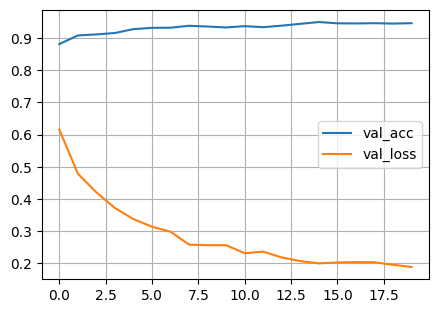

### Layer Normalization



In [ ]:
# MLP model
loss_function = nn.CrossEntropyLoss()
class MLP_LN(pl.LightningModule):
    def __init__(self):
        super(MLP_LN, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.LayerNorm(10))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = MLP_LN()
summary(model, input_size=(_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP_LN                                   [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Flatten: 2-1                      [32, 784]                 --
│    └─Linear: 2-2                       [32, 32]                  25,120
│    └─LayerNorm: 2-3                    [32, 32]                  64
│    └─ReLU: 2-4                         [32, 32]                  --
│    └─Linear: 2-5                       [32, 10]                  330
│    └─LayerNorm: 2-6                    [32, 10]                  20
Total params: 25,534
Trainable params: 25,534
Non-trainable params: 0
Total mult-adds (M): 0.82
Input size (MB): 0.10
Forward/backward pass size (MB): 0.02
Params size (MB): 0.10
Estimated Total Size (MB): 0.22

In [ ]:
model = MLP_LN()
name = "mlp_ln"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger,accelerator="auto",
                     limit_train_batches=0.15,limit_val_batches=0.25)
trainer.fit(model, trainDataLoader, val_dataloaders=valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 25.5 K
--------------------------------------
25.5 K    Trainable params
0         Non-trainable params
25.5 K    Total params
0.102     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
mlp_ln_v_num = logger.version
history2 = pd.read_csv(f'logs/{name}/version_{mlp_ln_v_num}/metrics.csv')
df = history2.groupby('epoch').mean().drop('step', axis=1)

In [ ]:
print('MaxAcc[',df['val_acc'].max(),']')
plt.plot(df['val_acc'], linestyle='-', label="val_acc")
plt.plot(df['val_loss'], linestyle='-', label="val_loss")

#plt.ylim(0.1,1.1)
plt.legend()
plt.grid()
plt.show()

MaxAcc[ 0.9539262652397156 ]
 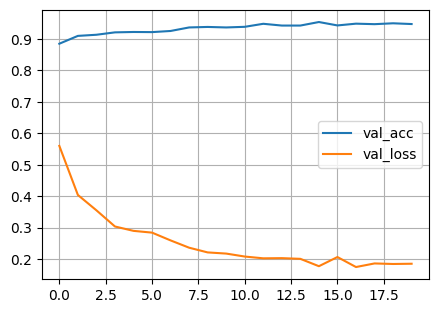

### Weight Normalization

In [ ]:
# MLP model
loss_function = nn.CrossEntropyLoss()
class MLP_WN(pl.LightningModule):
    def __init__(self):
        super(MLP_WN, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.utils.weight_norm(nn.Linear(784, 32)),
            nn.ReLU(),
            nn.utils.weight_norm(nn.Linear(32, 10)))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

mlp_wn = MLP_WN()
summary(mlp_wn, input_size=(_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP_WN                                   [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Flatten: 2-1                      [32, 784]                 --
│    └─Linear: 2-2                       [32, 32]                  25,152
│    └─ReLU: 2-3                         [32, 32]                  --
│    └─Linear: 2-4                       [32, 10]                  340
Total params: 25,492
Trainable params: 25,492
Non-trainable params: 0
Total mult-adds (M): 25.83
Input size (MB): 0.10
Forward/backward pass size (MB): 0.01
Params size (MB): 0.10
Estimated Total Size (MB): 0.21

In [ ]:
from pytorch_lightning.accelerators import accelerator
logger = pl.loggers.CSVLogger("logs", name="mlp_wn")
trainer = pl.Trainer(max_epochs=_epochs, logger=logger,accelerator="auto",
                     limit_train_batches=0.15,limit_val_batches=0.25)
trainer.fit(mlp_wn, trainDataLoader, val_dataloaders=valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 25.5 K
--------------------------------------
25.5 K    Trainable params
0         Non-trainable params
25.5 K    Total params
0.102     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
mlp_wn_v_num = logger.version
history3 = pd.read_csv(f'logs/mlp_wn/version_{mlp_wn_v_num}/metrics.csv')
df = history3.drop('step', axis=1).groupby('epoch').mean()

In [ ]:
print('MaxAcc[',df['val_acc'].max(),']')
plt.plot(df['val_acc'], linestyle='-', label="val_acc")
plt.plot(df['val_loss'], linestyle='-', label="val_loss")

#plt.ylim(0.1,1.1)
plt.legend()
plt.grid()
plt.show()

MaxAcc[ 0.9274839758872986 ]
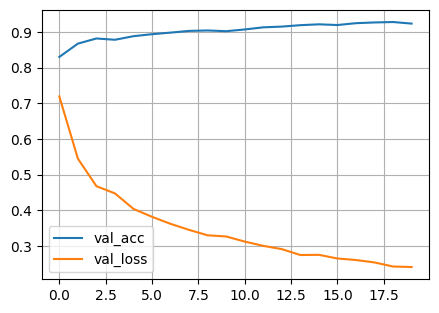

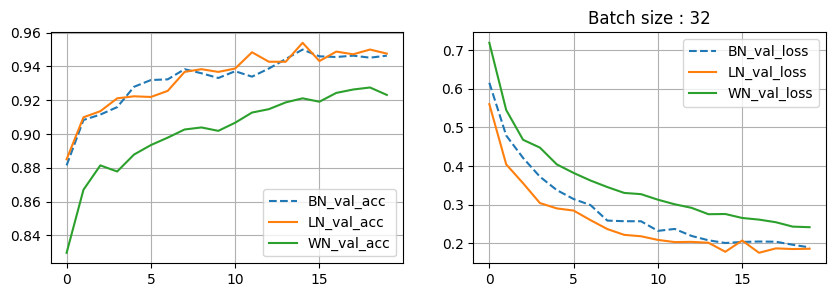

In [ ]:
history1_plot = history.drop('step', axis=1).groupby('epoch').mean()
history2_plot = history2.drop('step', axis=1).groupby('epoch').mean()
history3_plot = history3.drop('step', axis=1).groupby('epoch').mean()

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(history1_plot['val_acc'], linestyle='--', label="BN_val_acc")
plt.plot(history2_plot['val_acc'], linestyle='-', label="LN_val_acc")
plt.plot(history3_plot['val_acc'], linestyle='-', label="WN_val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(history1_plot['val_loss'], linestyle='--', label="BN_val_loss")
plt.plot(history2_plot['val_loss'], linestyle='-', label="LN_val_loss")
plt.plot(history3_plot['val_loss'], linestyle='-', label="WN_val_loss")
plt.title(f'Batch size : {_batch_size}')
#plt.ylim(0, 2.5)
plt.legend()
plt.grid()
plt.show()

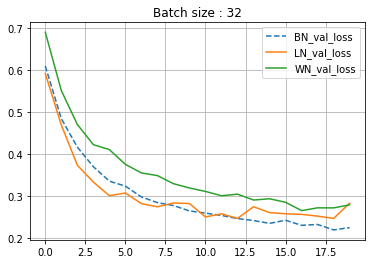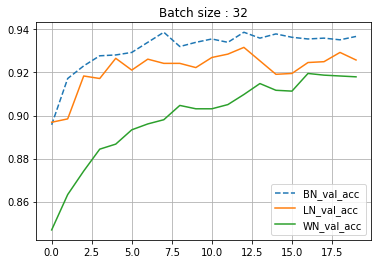

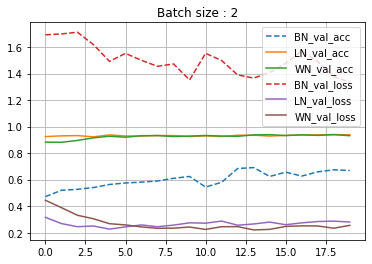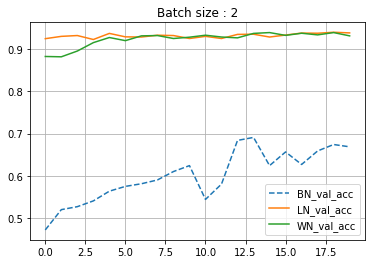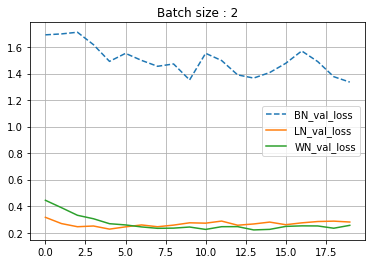

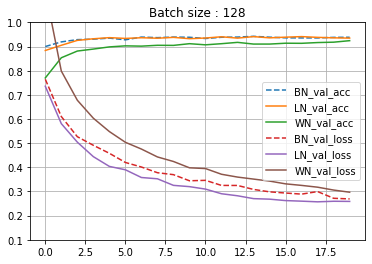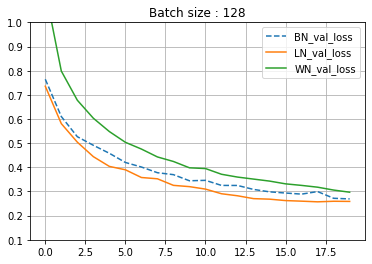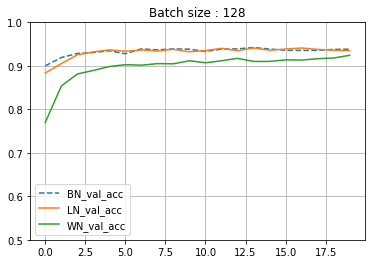

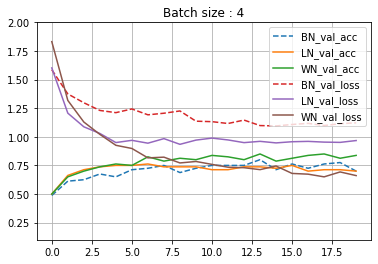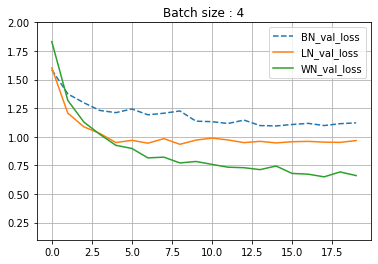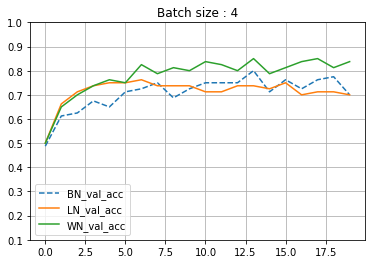

# Learning rate control

In [ ]:
# Batch size 수정하여 Dataset 준비
_batch_size = 128

download_root = './MNIST'
train_dataset = MNIST(download_root, train=True, download=True,transform=ToTensor())
trainDataLoader = DataLoader(train_dataset, _batch_size, True)

test_dataset = MNIST(download_root, train=False, download=True,transform=ToTensor())
valDataLoader = DataLoader(test_dataset, _batch_size, False)

- model define

In [ ]:
loss_function = nn.CrossEntropyLoss()

class CNN(pl.LightningModule):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 32, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32*3*3, 10)
        )
    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)

cnn = CNN()
summary(cnn, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 64, 28, 28]           640
│    └─ReLU: 2-2                         [8, 64, 28, 28]           --
│    └─MaxPool2d: 2-3                    [8, 64, 14, 14]           --
│    └─Conv2d: 2-4                       [8, 128, 14, 14]          73,856
│    └─ReLU: 2-5                         [8, 128, 14, 14]          --
│    └─MaxPool2d: 2-6                    [8, 128, 7, 7]            --
│    └─Conv2d: 2-7                       [8, 32, 7, 7]             36,896
│    └─ReLU: 2-8                         [8, 32, 7, 7]             --
│    └─MaxPool2d: 2-9                    [8, 32, 3, 3]             --
│    └─Flatten: 2-10                     [8, 288]                  --
│    └─Linear: 2-11                      [8, 10]                   2,890
Tot

- learning rate scheduling function

In [ ]:
_epochs = 50
epoch_n = _epochs #200
lr_start = 0.01

def manual_decay_lambda(epoch):
    if epoch/epoch_n > .75 :   return 0.05
    elif epoch/epoch_n > .5 : return 0.1
    elif epoch/epoch_n > .25 : return 0.5
    return 1

In [ ]:
decay_steps = _epochs//3
decay_rate=0.8
def exponential_decay_lambda(epoch):
    return decay_rate ** (epoch // decay_steps)

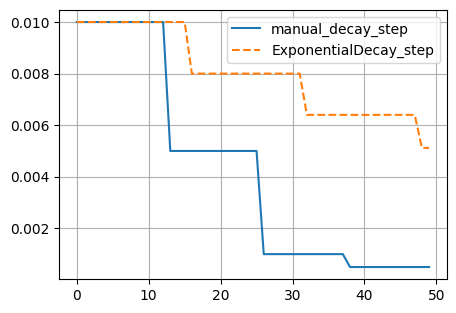

In [ ]:
man_lr_s=[]
exp_lr_s=[]

for step in range(epoch_n):
    man_lr_s.append(manual_decay_lambda(step)*lr_start)
    exp_lr_s.append(exponential_decay_lambda(step)*lr_start)

plt.plot(man_lr_s, linestyle='-', label="manual_decay_step")
plt.plot(exp_lr_s, linestyle='--', label="ExponentialDecay_step")
plt.legend()
plt.grid()
plt.show()

In [ ]:
class CNN_1(CNN): ## Inherit the CNN model
    def __init__(self):
        super(CNN_1, self).__init__()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=lr_start)

In [ ]:
%%time
cnn = CNN_1()
logger = pl.loggers.CSVLogger("logs", name="cnn")
trainer = pl.Trainer(max_epochs=_epochs, logger=logger,accelerator="auto",
                      overfit_batches=0.05)
trainer.fit(cnn, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 114 K 
--------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.457     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:261: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 36.9 s, sys: 471 ms, total: 37.4 s
Wall time: 37.3 s


In [ ]:
class CNN_2(CNN): ## Inherit the CNN model
    def __init__(self):
        super(CNN_2, self).__init__()

    def configure_optimizers(self):
        optimizer =  torch.optim.Adam(self.parameters(), lr=lr_start)
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = exponential_decay_lambda, verbose=True)
        return [optimizer], [lr_scheduler]

In [ ]:
%%time
cnn2 = CNN_2()
logger2 = pl.loggers.CSVLogger("logs", name="cnn_exp_decay")
trainer = pl.Trainer(max_epochs=_epochs, logger=logger2,accelerator="auto",
                     overfit_batches=0.05)
trainer.fit(cnn2, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 114 K 
--------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.457     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-02.


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:261: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.1200e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.1200e-03.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.1200e-03.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 37.2 s, sys: 409 ms, total: 37.6 s
Wall time: 37.5 s


In [ ]:
cnn_v_num = logger.version
cnn2_v_num = logger2.version

In [ ]:
history1 = pd.read_csv(f'logs/cnn/version_{cnn_v_num}/metrics.csv')
history1_plot = history1.drop('step', axis=1).groupby('epoch').last()

history2 = pd.read_csv(f'logs/cnn_exp_decay/version_{cnn2_v_num}/metrics.csv')
history2_plot = history2.drop('step', axis=1).groupby('epoch').last()

In [ ]:
print('Normal: max val_acc[',history1_plot['val_acc'].max(),']')
print('Exp_decay: max val_acc[',history2_plot['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(history1_plot['val_acc'], linestyle='--', label="noraml_val_acc")
plt.plot(history2_plot['val_acc'], linestyle='-', label="exp_schedule_val_acc")
#plt.ylim(0.1, 0.9)
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(history1_plot['val_loss'], linestyle='--', label="normal_val_loss")
plt.plot(history2_plot['val_loss'], linestyle='-', label="exp_schedule_val_loss")
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

Normal: max val_acc[ 0.9817708134651184 ]
Exp_decay: max val_acc[ 0.984375 ]
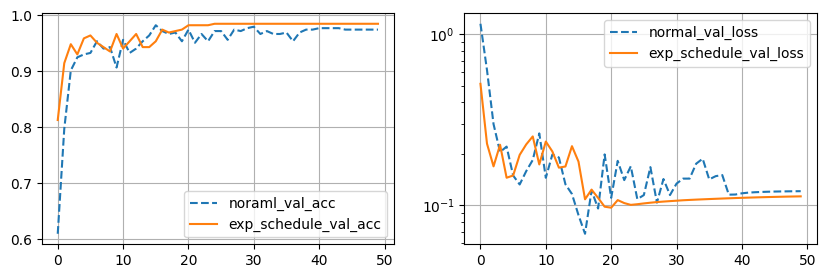

Normal: max val_acc[ 0.95849609375 ]
Exp_decay: max val_acc[ 0.970703125 ]
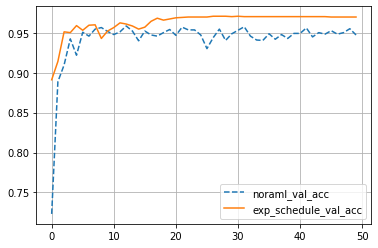 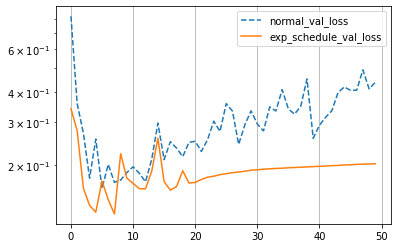